In [12]:
# =========================================================
# STEP 0 — Setup
# =========================================================
# (If needed) pip install:
# !pip install pandas numpy scikit-learn matplotlib openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest


In [13]:
# =========================================================
# STEP 1 — Load Excel
# =========================================================
EXCEL_PATH = r"D:\IITB\PLACEMENT\RESUME_PREP\DS PROJ\UPI+Transactions.xlsx"  # <-- change if needed

# If your data is in the first sheet:
df = pd.read_excel(EXCEL_PATH)  # or: pd.read_excel(EXCEL_PATH, sheet_name="Sheet1")

# Tidy column names
df.columns = df.columns.astype(str).str.strip()

print("Shape:", df.shape)
df.head()


Shape: (20000, 20)


,TransactionID,TransactionDate,Amount,BankNameSent,BankNameReceived,RemainingBalance,City,Gender,TransactionType,Status,TransactionTime,DeviceType,PaymentMethod,MerchantName,Purpose,CustomerAge,PaymentMode,Currency,CustomerAccountNumber,MerchantAccountNumber
0,TXN00001,2024-02-02,271.64,SBI Bank,HDFC Bank,5557.02,Delhi,Female,Transfer,Success,17:12:14,Tablet,Phone Number,Amazon,Food,21,Scheduled,USD,123456789013,987654321013
1,TXN00002,2024-03-03,1064.63,ICICI Bank,SBI Bank,9753.32,Bangalore,Male,Payment,Success,11:15:02,Laptop,QR Code,Zomato,Travel,22,Instant,EUR,123456789014,987654321014
2,TXN00003,2024-04-04,144.15,Axis Bank,Axis Bank,7597.35,Hyderabad,Female,Transfer,Success,21:29:39,Mobile,UPI ID,Swiggy,Bill Payment,23,Scheduled,GBP,123456789015,987654321015
3,TXN00004,2024-05-05,612.89,HDFC Bank,ICICI Bank,2327.84,Mumbai,Male,Payment,Success,06:27:36,Tablet,Phone Number,IRCTC,Others,24,Instant,INR,123456789016,987654321016
4,TXN00005,2024-06-06,743.32,SBI Bank,HDFC Bank,1136.84,Delhi,Female,Transfer,Failed,02:06:22,Laptop,QR Code,Flipkart,Shopping,25,Scheduled,USD,123456789017,987654321017


In [15]:
# =========================================================
# STEP 2 — Basic validation & cleaning (safe version)
# =========================================================
import pandas as pd
import numpy as np

# Expected columns
expected_cols = [
    "TransactionID","TransactionDate","Amount","BankNameSent","BankNameReceived",
    "RemainingBalance","City","Gender","TransactionType","Status","TransactionTime",
    "DeviceType","PaymentMethod","MerchantName","Purpose","CustomerAge",
    "PaymentMode","Currency","CustomerAccountNumber","MerchantAccountNumber"
]

# Check for missing columns
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("⚠️ Missing columns:", missing)

# Clean categorical text columns
cat_cols = [
    "BankNameSent","BankNameReceived","City","Gender","TransactionType","Status",
    "DeviceType","PaymentMethod","MerchantName","Purpose","PaymentMode","Currency"
]
for c in cat_cols:
    if c in df.columns:
        df[c] = (
            df[c]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({"nan": np.nan})  # avoid "nan" strings
        )

# Convert numeric columns safely
num_cols = ["Amount","RemainingBalance","CustomerAge"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Parse dates
if "TransactionDate" in df.columns:
    df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], errors="coerce")

# Parse times (store as Python time objects or None)
if "TransactionTime" in df.columns:
    tt = pd.to_datetime(df["TransactionTime"], errors="coerce")
    df["TransactionTime"] = tt.dt.time.where(tt.notna(), None)  # object dtype

# Combine date and time into single datetime
if "TransactionDate" in df.columns:
    if "TransactionTime" in df.columns and df["TransactionTime"].notna().any():
        df["TxnDateTime"] = pd.to_datetime(
            df["TransactionDate"].astype(str).str.strip() + " " +
            df["TransactionTime"].astype(str).str.strip(),
            errors="coerce"
        )
    else:
        df["TxnDateTime"] = df["TransactionDate"]

# Drop rows with no datetime or amount
df = df.dropna(subset=["TxnDateTime", "Amount"]).copy()

# Remove duplicates
df = df.drop_duplicates()
if "TransactionID" in df.columns:
    df = df.drop_duplicates(subset=["TransactionID"], keep="last")

print("✅ After cleaning:", df.shape)


✅ After cleaning: (20000, 21)


In [16]:
# =========================================================
# STEP 3 — Feature engineering
# =========================================================
# Time features
df["hour"] = df["TxnDateTime"].dt.hour
df["dayofweek"] = df["TxnDateTime"].dt.dayofweek  # 0=Mon
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)
df["month"] = df["TxnDateTime"].dt.month

# ---- Per-customer rolling stats & activity windows ----
def add_customer_stats(frame, id_col="CustomerAccountNumber", amt_col="Amount", ts_col="TxnDateTime"):
    f = frame.sort_values([id_col, ts_col]).copy()
    g = f.groupby(id_col, group_keys=False)

    # Rolling mean/std of last 10 txns (by count window)
    f["amt_mean_cust"] = g[amt_col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    f["amt_std_cust"]  = g[amt_col].transform(lambda x: x.rolling(10, min_periods=1).std()).fillna(0)

    # Gap between consecutive txns in minutes
    f["txn_gap_min"] = g[ts_col].transform(lambda x: x.diff().dt.total_seconds().div(60)).fillna(1e6)

    # Rolling 7-day txn count (time-based window using datetime index)
    def rolling_7d_count(timeseries):
        s = pd.Series(1, index=pd.DatetimeIndex(timeseries))
        return s.rolling('7D').sum().values

    f["txn_count_7d"] = g[ts_col].transform(rolling_7d_count)

    return f

if {"CustomerAccountNumber","TxnDateTime","Amount"}.issubset(df.columns):
    df = add_customer_stats(df)

# Customer–merchant familiarity (how many times this pair occurred)
if {"CustomerAccountNumber","MerchantAccountNumber"}.issubset(df.columns):
    pair_counts = (
        df.groupby(["CustomerAccountNumber","MerchantAccountNumber"])
          .size()
          .rename("cust_merchant_count")
          .reset_index()
    )
    df = df.merge(pair_counts, on=["CustomerAccountNumber","MerchantAccountNumber"], how="left")
else:
    df["cust_merchant_count"] = np.nan

# Simple flags
df["high_amount_flag"] = (df["Amount"] > df["Amount"].median()).astype(int)
if "RemainingBalance" in df.columns:
    df["low_balance_flag"] = (df["RemainingBalance"] < df["RemainingBalance"].quantile(0.1)).astype(int)
else:
    df["low_balance_flag"] = 0

# Final feature buckets
categoricals = [
    "BankNameSent","BankNameReceived","City","Gender","TransactionType",
    "DeviceType","PaymentMethod","MerchantName","Purpose","PaymentMode","Currency"
]
numerics = [
    "Amount","RemainingBalance","CustomerAge",
    "hour","dayofweek","is_weekend","month",
    "amt_mean_cust","amt_std_cust","txn_gap_min","txn_count_7d",
    "cust_merchant_count","high_amount_flag","low_balance_flag"
]

available_cat = [c for c in categoricals if c in df.columns]
available_num = [c for c in numerics if c in df.columns]


In [17]:
# =========================================================
# STEP 4 — Transaction Segmentation (KMeans)
#       (treat each row as a transaction)
# =========================================================
# Choose a compact feature set for clustering (helps speed & stability)
cluster_features = [c for c in available_num if c in [
    "Amount","hour","dayofweek","is_weekend","amt_mean_cust","amt_std_cust","txn_gap_min","txn_count_7d"
]] + [c for c in available_cat if c in ["DeviceType","PaymentMethod","PaymentMode","City"]]

X_cluster = df[cluster_features].copy()

pre_cluster = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in cluster_features if c in available_cat]),
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler(with_mean=False))
        ]), [c for c in cluster_features if c in available_num]),
    ],
    remainder="drop"
)

Xc = pre_cluster.fit_transform(X_cluster)

# Pick K using a quick silhouette scan (sample if huge)
rng = np.random.default_rng(42)
if Xc.shape[0] > 20000:
    idx = rng.choice(Xc.shape[0], size=20000, replace=False)
    Xc_sample = Xc[idx]
else:
    idx = None
    Xc_sample = Xc

best_k, best_score, best_model = None, -1, None
for k in range(3, 7):  # try 3..6 clusters
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xc_sample)
    score = silhouette_score(Xc_sample, labels)
    if score > best_score:
        best_k, best_score, best_model = k, score, km

# Train final model on full data
kmeans_full = KMeans(n_clusters=best_k, n_init=30, random_state=42)
df["txn_cluster"] = kmeans_full.fit_predict(Xc)
print(f"Chosen K={best_k} with silhouette≈{best_score:.3f}")


Chosen K=3 with silhouette≈0.261


In [18]:
# =========================================================
# STEP 5 — Cluster profiling (readable segment summaries)
# =========================================================
def top_mode(s):
    try:
        return s.mode().iloc[0]
    except Exception:
        return np.nan

cluster_profile = (
    df.groupby("txn_cluster")
      .agg(
          n_transactions=("TransactionID", "count"),
          avg_amount=("Amount","mean"),
          med_amount=("Amount","median"),
          std_amount=("Amount","std"),
          avg_hour=("hour","mean"),
          frac_weekend=("is_weekend","mean"),
          top_city=("City", top_mode),
          top_device=("DeviceType", top_mode),
          top_paymethod=("PaymentMethod", top_mode),
          top_paymode=("PaymentMode", top_mode),
      )
      .reset_index()
      .sort_values("txn_cluster")
)

print(cluster_profile)

# Save profiles
out_dir = Path(EXCEL_PATH).parent
cluster_profile.to_csv(out_dir / "upi_cluster_profiles.csv", index=False)


   txn_cluster  n_transactions   avg_amount  med_amount  std_amount  avg_hour  \
0            0            7822   503.388853     504.495  290.068807       0.0   
1            1            7511  1501.140377    1503.880  288.935401       0.0   
2            2            4667   998.436051     992.550  574.768966       0.0   

   frac_weekend   top_city top_device top_paymethod top_paymode  
0           0.0  hyderabad     tablet  phone number   scheduled  
1           0.0      delhi     tablet  phone number   scheduled  
2           1.0     mumbai     laptop       qr code     instant  


In [20]:
# =========================================================
# STEP 6 — Unsupervised Anomaly Detection (Isolation Forest)
# =========================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

# Ensure available_cat and available_num are valid & present in df
available_cat = [c for c in available_cat if c in df.columns]
available_num = [c for c in available_num if c in df.columns]

if not available_cat and not available_num:
    raise ValueError("No valid features available for anomaly detection.")

anom_features = available_cat + available_num
X_anom = df[anom_features].copy()

# Preprocessing: categorical → OneHot, numeric → impute + scale
pre_anom = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), available_cat),
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler(with_mean=False))
        ]), available_num),
    ],
    remainder="drop"
)

# Transform features
X_anom_trans = pre_anom.fit_transform(X_anom)

# Isolation Forest
iso = IsolationForest(
    n_estimators=400,
    contamination=0.01,   # ~1% anomalies
    random_state=42,
    n_jobs=-1
)
iso.fit(X_anom_trans)

# Predictions and scores
df["iso_pred"] = iso.predict(X_anom_trans)      # -1 anomaly, 1 normal
scores = iso.score_samples(X_anom_trans)        # higher = less anomalous
df["anomaly_score"] = -scores                   # higher = more anomalous
df["is_suspicious"] = (df["iso_pred"] == -1).astype(int)

# Extract suspicious transactions
suspicious = (
    df.sort_values("anomaly_score", ascending=False)
      .loc[lambda x: x["is_suspicious"] == 1]
      .head(200)
      .copy()
)

# Columns to save (only keep those present in df)
suspicious_cols = [
    "TransactionID","TxnDateTime","Amount","City","DeviceType",
    "PaymentMethod","PaymentMode","MerchantName","BankNameSent",
    "BankNameReceived","anomaly_score"
]
suspicious_cols_present = list(pd.Index(suspicious_cols).intersection(df.columns))

# Save suspicious transactions CSV (only if any found)
if not suspicious.empty:
    suspicious[suspicious_cols_present].to_csv(out_dir / "upi_suspicious_transactions.csv", index=False)
else:
    print("⚠️ No suspicious transactions detected.")
    # Save empty file to maintain pipeline outputs
    pd.DataFrame(columns=suspicious_cols_present).to_csv(out_dir / "upi_suspicious_transactions.csv", index=False)

# Also save Excel with both outputs
with pd.ExcelWriter(out_dir / "upi_outputs.xlsx", engine="openpyxl") as writer:
    if 'cluster_profile' in globals():
        cluster_profile.to_excel(writer, sheet_name="cluster_profiles", index=False)
    suspicious[suspicious_cols_present].to_excel(writer, sheet_name="suspicious", index=False)

print("✅ Saved:", out_dir / "upi_suspicious_transactions.csv")
print("✅ Saved:", out_dir / "upi_outputs.xlsx")


✅ Saved: D:\IITB\PLACEMENT\RESUME_PREP\DS PROJ\upi_suspicious_transactions.csv
✅ Saved: D:\IITB\PLACEMENT\RESUME_PREP\DS PROJ\upi_outputs.xlsx


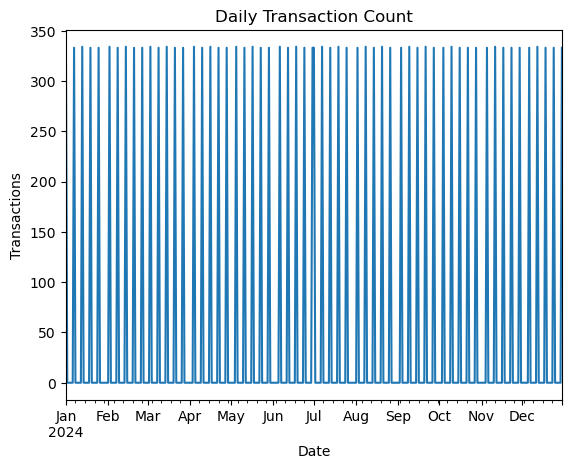

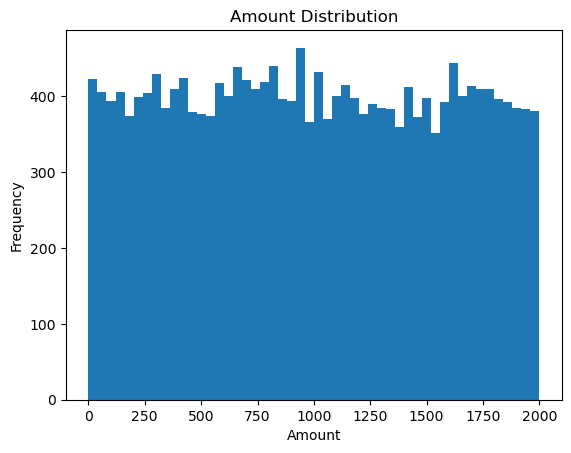

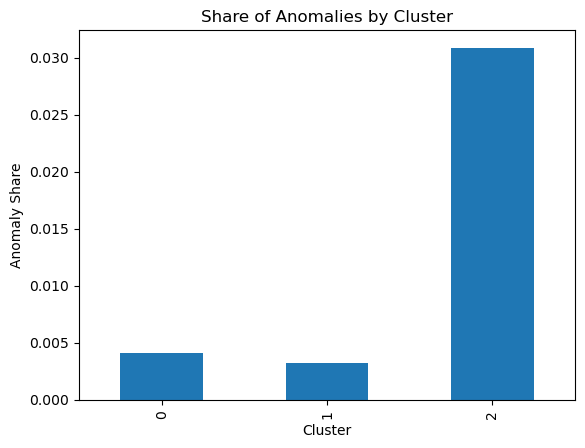

In [21]:
# =========================================================
# STEP 7 — Quick sanity plots (matplotlib only)
# =========================================================

# Daily transaction count
daily = df.set_index("TxnDateTime").resample("D")["TransactionID"].count()
plt.figure()
daily.plot(title="Daily Transaction Count")
plt.xlabel("Date"); plt.ylabel("Transactions")
plt.show()

# Amount distribution
plt.figure()
df["Amount"].dropna().plot(kind="hist", bins=50, title="Amount Distribution")
plt.xlabel("Amount"); plt.ylabel("Frequency")
plt.show()

# Anomaly share by cluster
anom_by_cluster = df.groupby("txn_cluster")["is_suspicious"].mean()
plt.figure()
anom_by_cluster.plot(kind="bar", title="Share of Anomalies by Cluster")
plt.xlabel("Cluster"); plt.ylabel("Anomaly Share")
plt.show()


In [22]:
# =========================================================
# STEP 8 — (Optional) Inspect a few anomalies
# =========================================================
cols_to_show = [
    "TransactionID","TxnDateTime","Amount","City","DeviceType","PaymentMode",
    "PaymentMethod","MerchantName","CustomerAccountNumber","MerchantAccountNumber",
    "anomaly_score","txn_cluster"
]
display_cols = [c for c in cols_to_show if c in df.columns]
df.loc[df["is_suspicious"]==1, display_cols].head(20)


,TransactionID,TxnDateTime,Amount,City,DeviceType,PaymentMode,PaymentMethod,MerchantName,CustomerAccountNumber,MerchantAccountNumber,anomaly_score,txn_cluster
26,TXN00027,2024-04-28,556.08,hyderabad,mobile,scheduled,upi id,zomato,123456789039,987654321039,0.594017,2
155,TXN00156,2024-01-07,236.49,mumbai,mobile,instant,upi id,amazon,123456789168,987654321168,0.590439,2
261,TXN00262,2024-11-23,1998.69,bangalore,tablet,instant,phone number,zomato,123456789274,987654321274,0.589434,2
425,TXN00426,2024-07-07,37.71,bangalore,mobile,instant,upi id,amazon,123456789438,987654321438,0.587261,2
446,TXN00447,2024-04-28,277.47,hyderabad,mobile,scheduled,upi id,zomato,123456789459,987654321459,0.606790,2
515,TXN00516,2024-01-07,1728.80,mumbai,mobile,instant,upi id,amazon,123456789528,987654321528,0.589780,2
875,TXN00876,2024-01-07,882.23,mumbai,mobile,instant,upi id,amazon,123456789888,987654321888,0.586358,2
995,TXN00996,2024-01-07,1766.90,mumbai,mobile,instant,upi id,amazon,123456790008,987654322008,0.590803,2
1106,TXN01107,2024-04-28,1866.38,hyderabad,mobile,scheduled,upi id,zomato,123456790119,987654322119,0.602561,2
1166,TXN01167,2024-04-28,1732.73,hyderabad,mobile,scheduled,upi id,zomato,123456790179,987654322179,0.605667,2


C:\Users\Jeevitha\AppData\Local\Temp\ipykernel_13284\323822437.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="txn_cluster", data=df, palette="viridis")


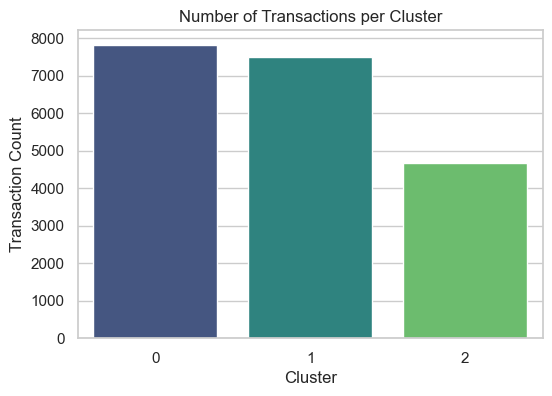

C:\Users\Jeevitha\AppData\Local\Temp\ipykernel_13284\323822437.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="txn_cluster", y="Amount", data=df, palette="mako", estimator=np.mean)


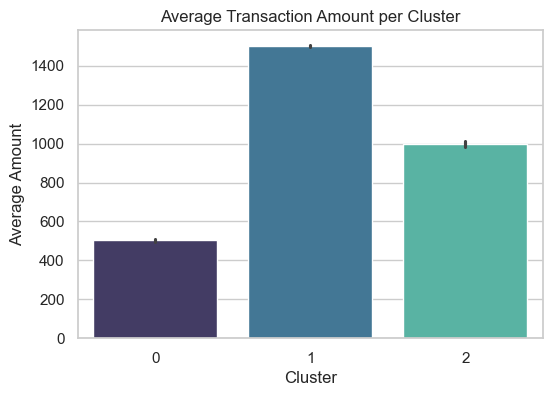

C:\Users\Jeevitha\AppData\Local\Temp\ipykernel_13284\323822437.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="txn_cluster", y="Amount", data=df, palette="Set2")


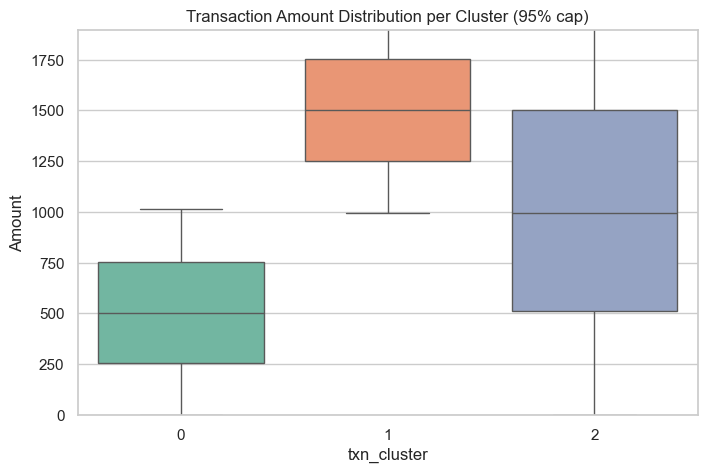

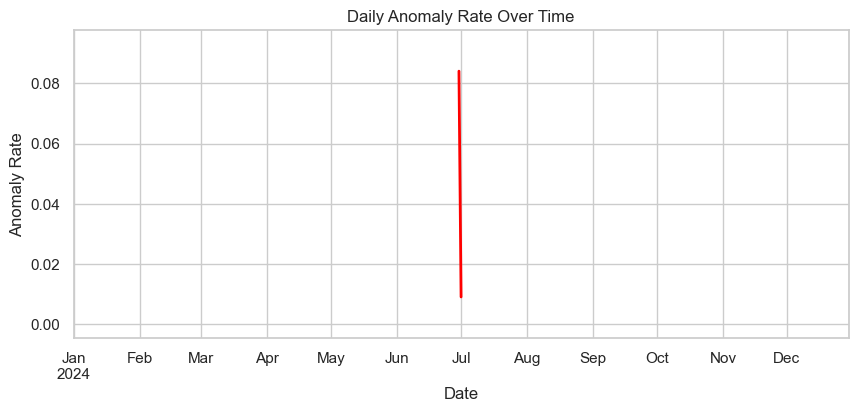

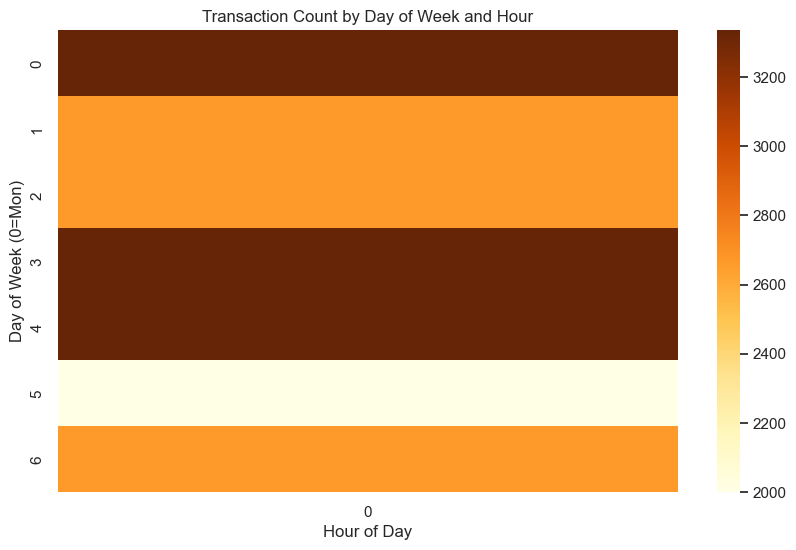

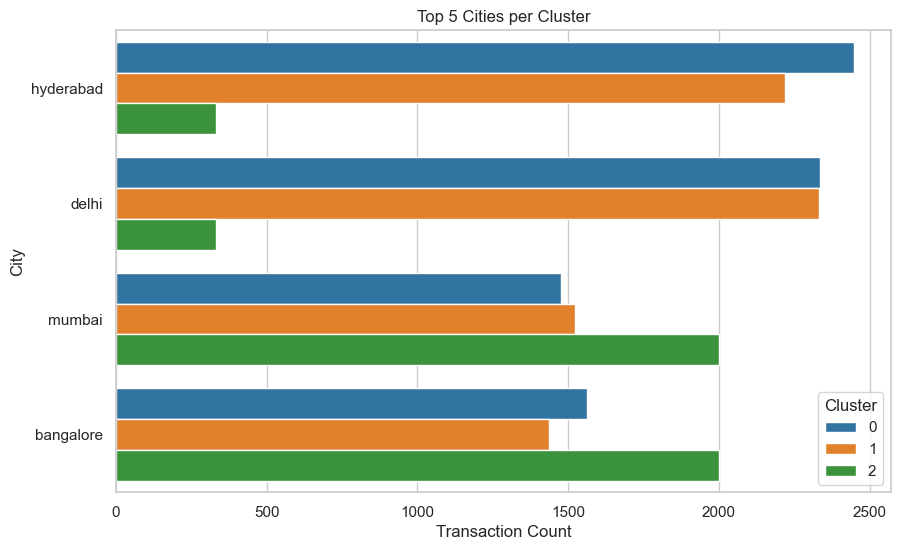

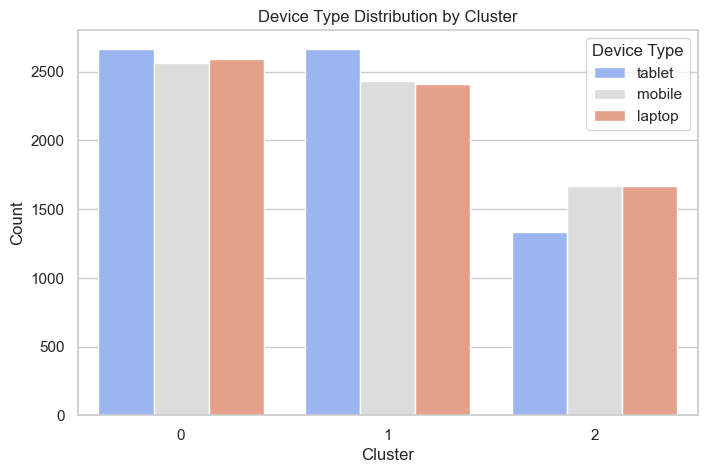

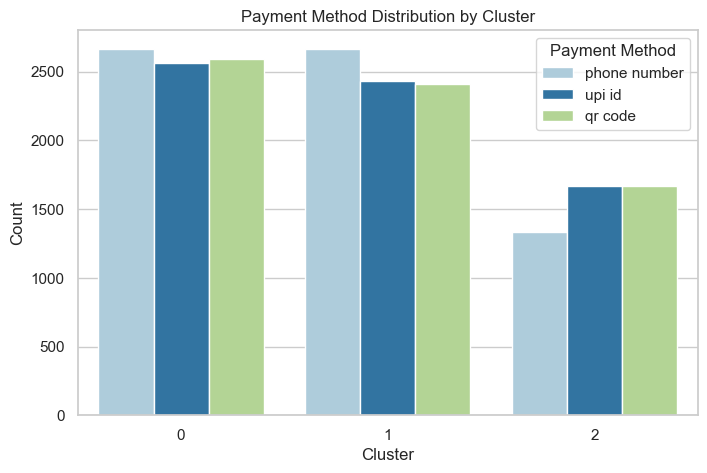

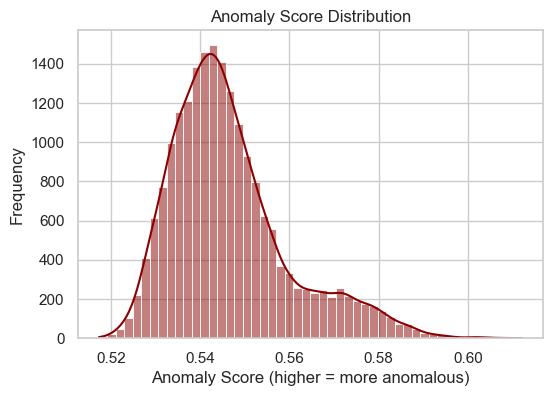

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


# Ensure seaborn style for nicer plots
sns.set(style="whitegrid")

# =========================
# 1. Cluster size distribution
# =========================
plt.figure(figsize=(6,4))
sns.countplot(x="txn_cluster", data=df, palette="viridis")
plt.title("Number of Transactions per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Transaction Count")
plt.show()

# =========================
# 2. Average amount by cluster
# =========================
plt.figure(figsize=(6,4))
sns.barplot(x="txn_cluster", y="Amount", data=df, palette="mako", estimator=np.mean)
plt.title("Average Transaction Amount per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Amount")
plt.show()

# =========================
# 3. Transaction amount distribution per cluster
# =========================
plt.figure(figsize=(8,5))
sns.boxplot(x="txn_cluster", y="Amount", data=df, palette="Set2")
plt.ylim(0, df["Amount"].quantile(0.95))  # cap y-axis for better visibility
plt.title("Transaction Amount Distribution per Cluster (95% cap)")
plt.show()

# =========================
# 4. Anomalies over time
# =========================
anom_time = df.set_index("TxnDateTime").resample("D")["is_suspicious"].mean()
plt.figure(figsize=(10,4))
anom_time.plot(color="red", lw=2)
plt.title("Daily Anomaly Rate Over Time")
plt.ylabel("Anomaly Rate")
plt.xlabel("Date")
plt.show()

# =========================
# 5. Heatmap: Hour of day vs. Day of week
# =========================
heat_df = df.groupby(["dayofweek", "hour"])["TransactionID"].count().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(heat_df, cmap="YlOrBr")
plt.title("Transaction Count by Day of Week and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon)")
plt.show()

# =========================
# 6. Top cities by cluster
# =========================
top_cities = df.groupby(["txn_cluster", "City"]).size().reset_index(name="count")
top_cities = top_cities.sort_values("count", ascending=False).groupby("txn_cluster").head(5)
plt.figure(figsize=(10,6))
sns.barplot(x="count", y="City", hue="txn_cluster", data=top_cities, palette="tab10")
plt.title("Top 5 Cities per Cluster")
plt.xlabel("Transaction Count")
plt.ylabel("City")
plt.legend(title="Cluster")
plt.show()

# =========================
# 7. Device type distribution by cluster
# =========================
plt.figure(figsize=(8,5))
sns.countplot(x="txn_cluster", hue="DeviceType", data=df, palette="coolwarm")
plt.title("Device Type Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Device Type")
plt.show()

# =========================
# 8. Payment method preference by cluster
# =========================
plt.figure(figsize=(8,5))
sns.countplot(x="txn_cluster", hue="PaymentMethod", data=df, palette="Paired")
plt.title("Payment Method Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Payment Method")
plt.show()

# =========================
# 9. Anomaly score distribution
# =========================
plt.figure(figsize=(6,4))
sns.histplot(df["anomaly_score"], bins=50, kde=True, color="darkred")
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Frequency")
plt.show()
